In [127]:
import pandas as pd 
import numpy as np
import sklearn as skl
import datasets
from sklearn.model_selection import train_test_split
import os

## Create Train / Validate / Test Set

In [82]:
# 1 is anti vaccine, 2 is pro vaccine, 0 is noise
train_anti_label = {
    'CovidIsACult' : 1, #done
    'covidskepticscanada': 1, #to be merged
    'FUCKCHINAVIRUS' : 1, #to be merged
    'ParentingWithoutFear': 1, #done
    'TrueAntiVaccination': 1, #to be merged
    'vaccinesideeffects' : 1, #to be merged
    'vacci_nation' : 1, #to be merged
    'NoNewNormal': 1, #done
}
train_pro_label = {
    'CoronaVaccines' : 2, #to merge
    'CovidVaccinated' : 2, #to merge
    'VACCINES': 2, #done

}

noise_label = {
    'aww': 0, # done
    'KidsAreFuckingStupid': 0, #done
    'natureismetal': 0, # done
}


### Submissions

In [3]:
df = pd.DataFrame()
for key in train_anti_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Submissions/train/'+key+'.pickle'))
    print(key, len(temp))
    df = pd.concat([df, temp])

df['label'] = df.subreddit.map(train_anti_label)

CovidIsACult 115
covidskepticscanada 3062
FUCKCHINAVIRUS 171
ParentingWithoutFear 216
TrueAntiVaccination 4394
vaccinesideeffects 467
vacci_nation 1899
NoNewNormal 109292


In [4]:
df2 = pd.DataFrame()
for key in train_pro_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Submissions/train/'+key+'.pickle'))
    print(key, len(temp))
    df2 = pd.concat([df2, temp])

df2['label'] = df2.subreddit.map(train_pro_label)

CoronaVaccines 307
CovidVaccinated 26721
VACCINES 4236
YouWillSurviveIt 725


In [5]:
df3 = pd.DataFrame()
for key in noise_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Submissions/train/'+key+'.pickle'))
    print(key, len(temp))
    df3 = pd.concat([df3, temp])

df3['label'] = df3.subreddit.map(noise_label)

aww 1251041
KidsAreFuckingStupid 52807
natureismetal 37221


In [6]:
print(len(df), len(df2), len(df3))

119616 31989 1341069


In [7]:

anti_train = df.sample(n=23000, random_state=42)
pro_train = df2.sample(n=23000, random_state=42)
noise_train = df3.sample(n=23000 , random_state = 42)

In [8]:
anti_temp = pd.concat([df, anti_train, anti_train]).drop_duplicates(keep=False)
pro_temp = pd.concat([df2, pro_train, pro_train]).drop_duplicates(keep=False)
noise_temp = pd.concat([df3, noise_train, noise_train]).drop_duplicates(keep=False)

In [9]:
train = pd.concat([anti_train, pro_train, noise_train]).sample(frac=1).reset_index(drop=True) #merge and shuffle

In [10]:
anti_val = anti_temp.sample(n=6000, random_state=42)
pro_val = pro_temp.sample(n=3200, random_state=42)
noise_val = noise_temp.sample(n=6000, random_state=42)

In [11]:
valid = pd.concat([anti_val, pro_val, noise_val]).sample(frac=1).reset_index(drop=True)

In [12]:
anti_test = pd.concat([anti_temp, anti_val, anti_val]).drop_duplicates(keep=False)
pro_test = pd.concat([pro_temp, pro_val, pro_val]).drop_duplicates(keep=False)
noise_test = pd.concat([noise_temp, noise_val, noise_val]).drop_duplicates(keep=False)

In [13]:
test = pd.concat([anti_test, pro_test, noise_test]).sample(frac=1).reset_index(drop=True)

In [14]:
print(len(train), len(valid), len(test))

69000 15200 1408474


In [15]:
train.drop('selftext', inplace=True, axis=1)
valid.drop('selftext', inplace=True, axis=1)
test.drop('selftext', inplace=True, axis=1)


In [16]:
train.groupby(by='label').count()

,author,created_utc,id,num_comments,permalink,score,subreddit,title,url
label,,,,,,,,,
0,23000,23000,23000,23000,23000,23000,23000,23000,23000
1,23000,23000,23000,23000,23000,23000,23000,23000,23000
2,23000,23000,23000,23000,23000,23000,23000,23000,23000


In [17]:
valid.groupby(by='label').count()

,author,created_utc,id,num_comments,permalink,score,subreddit,title,url
label,,,,,,,,,
0,6000,6000,6000,6000,6000,6000,6000,6000,6000
1,6000,6000,6000,6000,6000,6000,6000,6000,6000
2,3200,3200,3200,3200,3200,3200,3200,3200,3200


In [18]:
test.groupby(by='label').count()

,author,created_utc,id,num_comments,permalink,score,subreddit,title,url
label,,,,,,,,,
0,1312069,1312069,1312069,1312069,1312069,1312069,1312069,1312069,1312069
1,90616,90616,90616,90616,90616,90616,90616,90616,90616
2,5789,5789,5789,5789,5789,5789,5789,5789,5789


In [19]:
train['subreddit'].value_counts()

aww                     21529
NoNewNormal             20957
CovidVaccinated         19255
VACCINES                 3004
TrueAntiVaccination       872
KidsAreFuckingStupid      872
covidskepticscanada       630
natureismetal             599
YouWillSurviveIt          522
vacci_nation              366
CoronaVaccines            219
vaccinesideeffects         85
FUCKCHINAVIRUS             38
ParentingWithoutFear       36
CovidIsACult               16
Name: subreddit, dtype: int64

## Comments

### Merge Files for which 24 months were not be able to be downloaded (for valid reasons)

In [39]:
import datetime
start = int(datetime.datetime(2020, 3, 1).timestamp())
end = int(datetime.datetime(2022, 3, 31).timestamp())
split = 24
step = (end - start) / split
i = start
while i <= end:
    print(i, datetime.datetime.fromtimestamp(i))
    i += step

1583017200 2020-03-01 00:00:00
1585753050.0 2020-04-01 16:57:30
1588488900.0 2020-05-03 08:55:00
1591224750.0 2020-06-04 00:52:30
1593960600.0 2020-07-05 16:50:00
1596696450.0 2020-08-06 08:47:30
1599432300.0 2020-09-07 00:45:00
1602168150.0 2020-10-08 16:42:30
1604904000.0 2020-11-09 07:40:00
1607639850.0 2020-12-10 23:37:30
1610375700.0 2021-01-11 15:35:00
1613111550.0 2021-02-12 07:32:30
1615847400.0 2021-03-15 23:30:00
1618583250.0 2021-04-16 16:27:30
1621319100.0 2021-05-18 08:25:00
1624054950.0 2021-06-19 00:22:30
1626790800.0 2021-07-20 16:20:00
1629526650.0 2021-08-21 08:17:30
1632262500.0 2021-09-22 00:15:00
1634998350.0 2021-10-23 16:12:30
1637734200.0 2021-11-24 07:10:00
1640470050.0 2021-12-25 23:07:30
1643205900.0 2022-01-26 15:05:00
1645941750.0 2022-02-27 07:02:30
1648677600.0 2022-03-31 00:00:00


In [79]:
files = []
for key, value in train_pro_label.items():
    files.append(key)

In [80]:
for file in files:

    merge_data = os.listdir('../../../Files/Comments/temp')
    merged_data = [k for k in merge_data if k.startswith(file)]

    if len(merged_data) > 0:
        df = pd.concat([pd.read_pickle(os.path.join('../../../Files/Comments/temp',candidate)) for candidate in merged_data])
        df.to_pickle(f'../../../Files/Comments/train/{file}.pickle')
        print(f'{file} merged')
        for i in merged_data:
            os.remove(os.path.join('../../../Files/Comments/temp',i))

CoronaVaccines merged
CovidVaccinated merged
VACCINES merged


In [62]:
file

'covidskepticscanada'

In [74]:
merged_data.sort()

In [81]:
merged_data

['VACCINES-1640470050.pickle',
 'VACCINES-1624054950.pickle',
 'VACCINES-1618583250.pickle']

### Generate Training Data

In [83]:
df = pd.DataFrame()
for key in train_anti_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Comments/train/'+key+'.pickle'))
    print(key, len(temp))
    df = pd.concat([df, temp])

df['label'] = df.subreddit.map(train_anti_label)

CovidIsACult 60
covidskepticscanada 4460
FUCKCHINAVIRUS 6
ParentingWithoutFear 1749
TrueAntiVaccination 29031
vaccinesideeffects 1031
vacci_nation 3429
NoNewNormal 2029455


In [84]:
df2 = pd.DataFrame()
for key in train_pro_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Comments/train/'+key+'.pickle'))
    print(key, len(temp))
    df2 = pd.concat([df2, temp])

df2['label'] = df2.subreddit.map(train_pro_label)

CoronaVaccines 1129
CovidVaccinated 260610
VACCINES 14897


In [86]:
df3 = pd.DataFrame()
for key in noise_label:
    temp = pd.read_pickle(os.path.join('../../../Files/Comments/train/'+key+'.pickle'))
    print(key, len(temp))
    df3 = pd.concat([df3, temp])

df3['label'] = df3.subreddit.map(noise_label)

aww 7435352
KidsAreFuckingStupid 1714125
natureismetal 1478510


In [87]:
print(len(df), len(df2), len(df3))

2069221 276636 10627987


In [92]:

anti_train = df.sample(n=100000, random_state=42)
pro_train = df2.sample(n=100000, random_state=42)
noise_train = df3.sample(n=100000 , random_state=42)

In [93]:
# Create temp df to avoid having spillage in our validation & test dataset
anti_temp = pd.concat([df, anti_train, anti_train]).drop_duplicates(keep=False)
pro_temp = pd.concat([df2, pro_train, pro_train]).drop_duplicates(keep=False)
noise_temp = pd.concat([df3, noise_train, noise_train]).drop_duplicates(keep=False)

In [94]:
train = pd.concat([anti_train, pro_train, noise_train]).sample(frac=1).reset_index(drop=True) #merge and shuffle

In [95]:
anti_val = anti_temp.sample(n=50000, random_state=42)
pro_val = pro_temp.sample(n=10000, random_state=42)
noise_val = noise_temp.sample(n=100000, random_state=42)

In [96]:
#since there are so many comment, we will sample from these as well
anti_test = pd.concat([anti_temp, anti_val, anti_val]).drop_duplicates(keep=False).sample(n=80000, random_state=42)
pro_test = pd.concat([pro_temp, pro_val, pro_val]).drop_duplicates(keep=False).sample(n=10000, random_state=42)
noise_test = pd.concat([noise_temp, noise_val, noise_val]).drop_duplicates(keep=False).sample(n=140000, random_state=42)

In [97]:
valid = pd.concat([anti_val, pro_val, noise_val]).sample(frac=1).reset_index(drop=True)

In [98]:
test = pd.concat([anti_test, pro_test, noise_test]).sample(frac=1).reset_index(drop=True)

In [99]:
print(len(train), len(valid), len(test))

300000 160000 230000


In [103]:
test.drop('index', inplace=True, axis=1)

In [113]:
train.drop('index', inplace=True, axis=1)
valid.drop('index', inplace=True, axis=1)

## Text Preprocessing

In [110]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')

In [111]:
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleantext = re.sub(r'[^\w\s]', '', sentence)
    rem_url=re.sub(r'http\S+', '[URL]',cleantext)
    rem_num = re.sub('[0-9]+', '[NUM]', rem_url)
    lemma_words = [token.lemma_ for token in nlp(rem_num) if not token.is_stop]
    return " ".join(lemma_words)

### Preprocessing for Post Data

In [115]:
subset = train[0:100].copy()

In [116]:
subset['body']=subset['body'].map(lambda s:preprocess(s)) 

In [117]:
subset.body

0     canadian sheep sheep covid[num ] vaccine \n\n ...
1     read study tell methodology conduct question a...
2                                                remove
3                                                remove
4     sheep slaughter horrible happening stand belie...
                            ...                        
95                          expect know definitely case
96    gttry read articlesinstead react twitter post ...
97            second lynx eat bird video ve see morning
98    not monitor people long particular vaccine s m...
99    wow not jesus sell [ NUM ] peice silver \n\n m...
Name: body, Length: 100, dtype: object

In [34]:
train['cleanTitle']=train['title'].map(lambda s:preprocess(s)) 

In [35]:
valid['cleanTitle']=valid['title'].map(lambda s:preprocess(s)) 
test['cleanTitle']=test['title'].map(lambda s:preprocess(s)) 

In [ ]:
train.head()

,author,created_utc,id,num_comments,permalink,score,subreddit,title,url,label,cleanTitle
0,FUCK-YOU-SHILL-BOT,1626717793,onjiw2,19,/r/NoNewNormal/comments/onjiw2/the_shill_organ...,1,NoNewNormal,The Shill Organization,https://www.reddit.com/r/NoNewNormal/comments/...,1,shill organization
1,NoNewAbnormal,1611970473,l8agl0,1,/r/NoNewNormal/comments/l8agl0/canadian_minist...,1,NoNewNormal,"Canadian Minister of Health Patty Hajdu: ""bord...",https://www.reddit.com/r/NoNewNormal/comments/...,1,canadian minister health patty hajdu border me...
2,Fancy_Ppants,1630446410,pffnxc,1,/r/VACCINES/comments/pffnxc/a_step_in_the_righ...,1,VACCINES,A step in the right direction! Got the Dolly P...,https://i.redd.it/wbqozcvqkrk71.jpg,2,step right direction got dolly parton jab toda...
3,meowwwwza1,1612048331,l8yekp,3,/r/CovidVaccinated/comments/l8yekp/pfizer_dela...,1,CovidVaccinated,Pfizer delayed redness,https://www.reddit.com/r/CovidVaccinated/comme...,2,pfizer delayed redness
4,northmeetssouth4224,1631152009,pko3go,0,/r/VACCINES/comments/pko3go/i_want_the_vaccine...,1,VACCINES,I want the vaccine. I have 2 Pfizer. I want to...,https://www.reddit.com/r/VACCINES/comments/pko...,2,want vaccine pfizer want get moderna instead a...


In [36]:
train.to_pickle('../../../Files/Submissions/train/train_split_submission.pickle')
valid.to_pickle('../../../Files/Submissions/train/val_split_submission.pickle')
test.to_pickle('../../../Files/Submissions/train/test_split_submission.pickle')

In [6]:
valid = pd.read_pickle('../../../Files/Submissions/train/val_split_submission.pickle')
test = pd.read_pickle('../../../Files/Submissions/train/test_split_submission.pickle')

In [4]:
train = pd.read_pickle('../../../Files/Submissions/train/train_split_submission.pickle')

<AxesSubplot:>

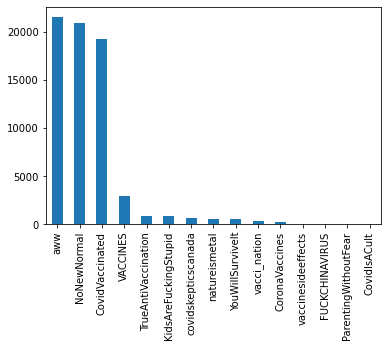

In [4]:
train['subreddit'].value_counts().plot(kind='bar')

### Preprocessing for Comments

In [118]:
train['cleanBody']=train['body'].map(lambda s:preprocess(s)) 

In [121]:
valid['cleanBody']=valid['body'].map(lambda s:preprocess(s)) 

In [124]:
test['cleanBody']=test['body'].map(lambda s:preprocess(s)) 

In [122]:
# train.to_pickle('../../../Files/Comments/train/train_split_submission.pickle')
valid.to_pickle('../../../Files/Comments/train/val_split_submission.pickle')


In [125]:
test.to_pickle('../../../Files/Comments/train/test_split_submission.pickle')

In [126]:
train = pd.read_pickle('../../../Files/Comments/train/train_split_submission.pickle')

FileNotFoundError: [Errno 2] No such file or directory: '../../../Files/Comments/train/train_split_submission.pickle'

## Preprocessing Posts for Scoring

In [5]:
files = os.listdir('../../../Files/Submissions/')

In [17]:
files = ['pics.pickle']

In [11]:
for file in files:
    if file[-7:] != ".pickle":
        files.pop(files.index(file))

In [18]:
from tqdm import tqdm

for file in tqdm(files):
    df = pd.read_pickle(os.path.join('../../../Files/Submissions/',file))
    df['cleanTitle']=df['title'].map(lambda s:preprocess(s)) 
    df.to_pickle(os.path.join('../../../Files/Submissions/',file))

100%|██████████| 1/1 [12:57<00:00, 777.01s/it]


In [43]:
files = os.listdir('../../../Files/Submissions/')

# remove any files that are not in the .pickle type 
files = [f for f in files if f.endswith('.pickle')]

In [44]:
len(files)

611

In [28]:
import csv
from itertools import chain
with open('../../Preprocessing/subreddits_sm.csv', newline='') as f:
    reader = csv.reader(f)
    subreddits = list(reader)

subreddits = list(chain.from_iterable(subreddits))

In [30]:
files[0][:-7]

'Qult_Headquarters'

In [67]:
for file in files:
    if file[:-7] not in subreddits:
        files.pop(files.index(file))


In [58]:
len(subreddits)

298

In [72]:
for file in files:
    #move file to the score directory
    os.rename(os.path.join('../../../Files/Submissions/',file), os.path.join('../../../Files/Submissions/score/',file))


In [71]:
files.index('AIandRobotics.pickle')

ValueError: 'AIandRobotics.pickle' is not in list